In [1]:
import time
import os
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertJapaneseTokenizer, AutoTokenizer, AutoModelForSequenceClassification 
from transformers import EarlyStoppingCallback
from transformers import pipeline
import matplotlib as plt
import matplotlib.style

In [2]:
def load_best_model(corpus, tgt, label_orientation):
    import torch
    
    path = f'ckpt/{corpus}/{tgt}/{label_orientation}/'
    best_acc, best_f1, best_epoch, best_file, best_pretrained_model_name = -1, -1, -1, None, None
    
    for file in os.listdir(path):
        try:
#             acc_{metric_dict['accuracy']}_f1_{metric_dict['f1']}_vloss_{val_loss}_epoch_{epoch}_{pretrained_model_name}.pt
            _, acc, _, f1, _, loss, _, epoch, _, lr, pretrained_model_name = file.split("_")
            pretrained_model_name = pretrained_model_name[:-3]
            pretrained_model_name = pretrained_model_name.replace(")(","/")
        except:
            continue
        acc = float(acc)
        f1 = float(f1)
        epoch = int(epoch)
        if f1 > best_f1:
            best_file = file
            best_epoch = epoch
            best_acc = acc
            best_f1 = f1
            best_pretrained_model_name = pretrained_model_name
        elif f1 == best_f1:
            if acc > best_acc:
                best_file = file
                best_epoch = epoch
                best_acc = acc
                best_f1 = f1
                best_pretrained_model_name = pretrained_model_name               
    if best_file:
        file_path = path + best_file
        if tgt == 'ja':
            tokenizer = BertJapaneseTokenizer.from_pretrained(best_pretrained_model_name)
        else:
            tokenizer = AutoTokenizer.from_pretrained(best_pretrained_model_name)
        model = AutoModelForSequenceClassification.from_pretrained(best_pretrained_model_name)
        model.load_state_dict(torch.load(file_path)['model'])
        print(f'[!] Load the model from {file_path}')
    else:
        raise Exception(f"[!] No saved model")
    return model, tokenizer


In [3]:
def get_data_as_list(path):
    data = []
    with open(path, 'r', encoding='utf-8-sig')as f:
        reader = csv.reader(f)
        for row in reader:
            data.append(row)
    return data
def get_mrphdata_as_list(path):
    data = []
    with open(path, 'r', encoding='utf-8-sig')as f:
        reader = csv.reader(f)
        for row in reader:
            try:
                row = row[0].split(' ')
            except:
                pass
            data.append(row)
    return data
def get_clause(unaligned,mrph):
    pattern = ['？','！','、','。','’','「','」','，',
       '？','！','，','、','。','‘','‘','“','“','「','」',
      '？','！','，','、','。','‘','’','“','”','「','」']
    idx_list = []
    for idx in unaligned:
        idx = int(idx)
        if w == mrph[idx]:
            
            idx_list.append(idx)
    clause = []
    for idx in idx_list:
        start=0
        for i in reversed(range(idx)):
            if mrph[i] in pattern:
                start = i+1
                break
        end = -1
        for j in (range(idx,len(HT_mrph[l]))):
            if mrph[j] in pattern:
                end = j+1
                break
        clause.append(mrph[start:end])
    return clause

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tgt = 'zh'
corpus = 'Friends'
label_orientation = "posinega"

model,tokenizer = load_best_model(corpus, tgt, label_orientation)

if tgt=='ja':
    sig_list=[
    #             ['del','cejc','query','request','Trust'],
    #             ['del','cejc','query','thanksgiving','Trust'],
    #             ['del','cejc','res','request','Trust'],
                ['add','mpdd','query','apology','Disgust'],
                ['add','mpdd','query','request','Sadness'], 
                ['add','mpdd','query','request','Disgust'],
                ['add','mpdd','query','request','Joy'],
                ['add','mpdd','query','thanksgiving','Sadness'],
                ['add','mpdd','query','thanksgiving','Disgust'],
                ['add','mpdd','query','thanksgiving','Trust'], 
                ['add','mpdd','query','thanksgiving','Joy'],
                ['add','mpdd','res','request','Sadness'],
                ['add','mpdd','res','request','Disgust'],
                ['add','mpdd','res','request','Trust'],
                ['add','mpdd','res','request','Joy'],
                ['add','mpdd','res','thanksgiving','Sadness']]
    labeled_table_path = 'JIWC_diff_reason_table.csv'
else:
    sig_list=[  
#                 ['del',	'mpdd',	'query',	'request',		'affect'],
#                 ['del',	'mpdd',	'query',	'request',		'negemo'],
#                 ['del',	'mpdd',	'query',	'request',		'anger'],
#                 ['del',	'mpdd',	'res',	'thanksgiving',	'affect'],
                ['add',	'cejc',	'query',	'apology',	    'affect'],
                ['add',	'cejc',	'query',	'apology',	    'posemo'],
                ['add',	'cejc',	'query',	'apology',	    'negemo'],
                ['add',	'cejc',	'query',	'apology',	    'anger'],
                ['add',	'cejc',	'query',	'request',	    'negemo'],
                ['add',	'cejc',	'res',	'request',	    'affect'],
                ['add',	'cejc',	'res',	'request',	    'posemo']]
    labeled_table_path = 'CLIWC_diff_reason_table.csv'

columns_name=['diff_type','corpus','situation','sen_type','emotion','word','htmt','line','part','effect','direct','intence','perspective']
df = pd.read_csv(labeled_table_path, names=columns_name)
# REPLACE subordinate concept to MOREorLESS intencity
more =   ['lessdowngrader','moreupgrader','morespecific','lessrespectful','lesshumble','add_expect_sth_in_return','add_irony']
less = ['moredowngrader','lessspecific','lessupgrader','morerespectful','morehumble','rmv_expect_sth_in_return','rmv_irony']

for m, l in zip(more, less):
    df=df.replace(m,'moreintence')
    df=df.replace(l,'lessintence')

index_names=[]
all_sentiment_table=[]
for s in sig_list:
    diff_type=s[0]
    corpus=s[1]
    sen_type=s[2]
    situation=s[3]
    emotion=s[4]
    # FILTER TABLE
    emo_cond = df['diff_type'].isin([diff_type]) & df['corpus'].isin([corpus]) & df['sen_type'].isin([sen_type]) & df['situation'].isin([situation]) & df['emotion'].isin([emotion])
    gizamiss_cond = df['part'].isin(['gizamiss','labelmiss'])
    line = df[emo_cond&~gizamiss_cond]['line'].to_list()
    word = df[emo_cond&~gizamiss_cond]['word'].to_list()
    # GET DATA
    if tgt == 'ja':
        MT_path = f'../data/mpdd/{situation}/translated_{sen_type}.csv'
        HT_path = f'../data/mpdd/{situation}/rewrited_{sen_type}.csv'
        MT_mrph_path = f'../mrphdata/mpdd/{situation}/translated_{sen_type}'
        HT_mrph_path = f'../mrphdata/mpdd/{situation}/rewrited_{sen_type}'
        MT_unaligned_path = f'../analysis/unaligned_index/mpdd/{situation}/translated_{sen_type}.{diff_type}'
        HT_unaligned_path = f'../analysis/unaligned_index/mpdd/{situation}/rewrited_{sen_type}.{diff_type}'
    elif tgt == 'zh':
        MT_path = f'../data/cejc/{situation}/translated_{sen_type}.csv'
        HT_path = f'../data/cejc/{situation}/rewrited_{sen_type}.csv'
        MT_mrph_path = f'../mrphdata/cejc/{situation}/translated_{sen_type}'
        HT_mrph_path = f'../mrphdata/cejc/{situation}/rewrited_{sen_type}'
        MT_unaligned_path = f'../analysis/unaligned_index/cejc/{situation}/translated_{sen_type}.{diff_type}'
        HT_unaligned_path = f'../analysis/unaligned_index/cejc/{situation}/rewrited_{sen_type}.{diff_type}'
    
    MT_data = get_data_as_list(MT_path)
    HT_data = get_data_as_list(HT_path)
    MT_unaligned = get_mrphdata_as_list(MT_unaligned_path)
    HT_unaligned = get_mrphdata_as_list(HT_unaligned_path)
    MT_mrph = get_mrphdata_as_list(MT_mrph_path)
    HT_mrph = get_mrphdata_as_list(HT_mrph_path)
    sentiment_table = []
    for l,w in zip(line,word):
        # GET CLAUSE WHICH HAS UNALIGNED WORD
        clause = get_clause(HT_unaligned[l],HT_mrph[l])
        print('clause: ',clause) 
        print('word:   ',w)
        # ADD THE CLAUSE TO MT-SENTENCE
        # 一番前に追加 
        sen = MT_mrph[l]
        for c in clause: 
            sen = c + sen
        MT_added_clause_front = ''.join(sen)
        # 一番後ろに追加 
        sen = MT_mrph[l]
        for c in clause: 
            sen = sen + c
        MT_added_clause_back = ''.join(sen)
        # DEL THE UNALIGNED WORD FROM HT-SENTENCE
        sen = ''.join(HT_mrph[l])
        for c in clause:   
            c = ''.join(c)
            sen = sen.replace(c,"")
        HT_removed_clause = sen
        # ADD THE UNALIGNED WORD TO MT-SENTENCE
        # 一番前に追加 
        MT_added_word_front = [w] + MT_mrph[l]
        MT_added_word_front = ''.join(MT_added_word_front)
        # 一番後ろに追加     
        MT_added_word_back = MT_mrph[l] + [w]
        MT_added_word_back = ''.join(MT_added_word_back)
        # DEL THE UNALIGNED WORD FROM HT-SENTENCE
        for idx in HT_unaligned[l]:
            idx = int(idx)
            if w == HT_mrph[l][idx]:
                HT_removed_word = HT_mrph[l]
                HT_removed_word[idx] = ''
        HT_removed_word = ''.join(HT_removed_word)
        
        MT_original = MT_data[l][0]
        HT_original = HT_data[l][0]
        obj_name_list = ['MT_original','HT_original','MT_added_clause_front','MT_added_clause_back','HT_removed_clause','MT_added_word_front','MT_added_word_back','HT_removed_word']    
        obj_list = [MT_original,HT_original,MT_added_clause_front,MT_added_clause_back,HT_removed_clause,MT_added_word_front,MT_added_word_back,HT_removed_word]    
        tmp = []
        for name,obj in zip(obj_name_list,obj_list):
            print('{0:<25}: {1}'.format(name, obj))
            ####################
            model.eval()
            encode = tokenizer(obj, padding=True, truncation=True, max_length=512)
            inputs = torch.LongTensor(encode['input_ids'])
            attention_masks = torch.LongTensor(encode['attention_mask'])
#             print(encode)
            inputs = inputs.unsqueeze(0)
            attention_masks = attention_masks.unsqueeze(0)
            with torch.no_grad():  
                if torch.cuda.is_available():
                    inputs = inputs.to(device)
                    attention_masks = attention_masks.to(device)
                    model.cuda()
                    outputs = model(input_ids=inputs, attention_mask=attention_masks)
            logit = outputs.logits.detach().cpu().numpy()
#             print(logit[0])
#             print(np.argmax(logit[0]))
            dct = [{'label': np.argmax(logit[0]),'score': logit[0]}]
            ####################              
#             dct = jp_classifier(obj)
            ####################
            tmp.append(dct[0]['label'])
            tmp.append(dct[0]['score'][0])
            tmp.append(dct[0]['score'][1])
        sentiment_table.append(tmp)
        index_name='{} {} {} {} {} {} {}'.format(diff_type,corpus,sen_type,situation,emotion,l,w,clause)
        index_names.append(index_name)
    all_sentiment_table.extend(sentiment_table)

column_names=[]
for n in obj_name_list:
    for key_n in ['label','posi','nega']:
        column_name = n + " " + key_n
        column_names.append(column_name)
# print(index_names)
# result = pd.DataFrame(all_sentiment_table,, )
result = pd.DataFrame(all_sentiment_table,columns=column_names,index=index_names)
print(result)

Some weights of the model checkpoint at nghuyong/ernie-1.0 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-1.0 and are

[!] Load the model from ckpt/Friends/zh/posinega/acc_0.9873150105708245_f1_0.9758064516129032_vloss_2.6135501861572266_epoch_5_lr_1e-05_nghuyong)(ernie-1.0.pt
clause:  [['但是', '外国人', '应该', '不', '符合', '资格', '吧', '？']]
word:    不
MT_original              : 這不是目標吧？。抱歉
HT_original              : 但是外國人應該不符合資格吧？抱歉。
MT_added_clause_front    : 但是外国人应该不符合资格吧？这不是目标吧？。抱歉
MT_added_clause_back     : 这不是目标吧？。抱歉但是外国人应该不符合资格吧？
HT_removed_clause        : 抱歉。
MT_added_word_front      : 不这不是目标吧？。抱歉
MT_added_word_back       : 这不是目标吧？。抱歉不
HT_removed_word          : 但是外国人应该符合资格吧？抱歉。
clause:  [['一个', '不', '小心', '就']]
word:    不
MT_original              : 對不起，我不知道
HT_original              : 抱歉，一個不小心就...
MT_added_clause_front    : 一个不小心就对不起，我不知道
MT_added_clause_back     : 对不起，我不知道一个不小心就
HT_removed_clause        : 抱歉，...
MT_added_word_front      : 不对不起，我不知道
MT_added_word_back       : 对不起，我不知道不
HT_removed_word          : 抱歉，一个小心就...
clause:  [['我', '不', '太', '能够', '判断', '到底', '什么', '是', '好', '的', '，']]
word:    

HT_original              : 抱歉，一個不小心就...
MT_added_clause_front    : 一个小心就对不起，我不知道
MT_added_clause_back     : 对不起，我不知道一个小心就
HT_removed_clause        : 抱歉，...
MT_added_word_front      : 小心对不起，我不知道
MT_added_word_back       : 对不起，我不知道小心
HT_removed_word          : 抱歉，一个就...
clause:  [['之前', '交给', '你', '的', '工作', '都', '是', '拜', '讬', '朝', '丘', '那边', '帮忙', '的对', '吧', '？']]
word:    帮忙
MT_original              : 給細田。。啊。。所以+對不起。。你和淺岡先生一起做過長石吧？。都倒下了。
HT_original              : 後來就交給細田了。啊，抱歉，之前交給你的工作都是拜託朝丘那邊幫忙的對吧？雖然說到後來他也是全部都外包給別人做就是了。
MT_added_clause_front    : 之前交给你的工作都是拜讬朝丘那边帮忙的对吧？给细田。。啊。。所以+对不起。。你和浅冈先生一起做过长石吧？。都倒下了。
MT_added_clause_back     : 给细田。。啊。。所以+对不起。。你和浅冈先生一起做过长石吧？。都倒下了。之前交给你的工作都是拜讬朝丘那边帮忙的对吧？
HT_removed_clause        : 后来就交给细田了。啊，抱歉，虽然说到后来他也是全部都外包给别人做就是了。
MT_added_word_front      : 帮忙给细田。。啊。。所以+对不起。。你和浅冈先生一起做过长石吧？。都倒下了。
MT_added_word_back       : 给细田。。啊。。所以+对不起。。你和浅冈先生一起做过长石吧？。都倒下了。帮忙
HT_removed_word          : 后来就交给细田了。啊，抱歉，之前交给你的工作都是拜讬朝丘那边的对吧？虽然说到后来他也是全部都外包给别人做就是了。
clause:  [['我', '不'

MT_added_clause_front    : 麻烦你了。抱歉
MT_added_clause_back     : 抱歉麻烦你了。
HT_removed_clause        : 不好意思，
MT_added_word_front      : 麻烦抱歉
MT_added_word_back       : 抱歉麻烦
HT_removed_word          : 不好意思，你了。
clause:  [['麻烦', '你', '了', '。']]
word:    麻烦
MT_original              : 對不起，我不知道
HT_original              : 不好意思，麻煩你了。
MT_added_clause_front    : 麻烦你了。对不起，我不知道
MT_added_clause_back     : 对不起，我不知道麻烦你了。
HT_removed_clause        : 不好意思，
MT_added_word_front      : 麻烦对不起，我不知道
MT_added_word_back       : 对不起，我不知道麻烦
HT_removed_word          : 不好意思，你了。
clause:  [['诶', '...', '大概', '今天', '或是', '明天', '会', '再', '跟', '大', '槻', '先生', '联络', '就', '可以', '了', '。']]
word:    可以
MT_original              : 我現在也會跟進的。。我只是打電話告訴你，我很抱歉。。求你了。在（。 大槻老師+那也許今天或明天+也許今天或明天，並聯繫了管理部門。
HT_original              : 現在已經在追蹤了。不好意思，那就再麻煩你跟他聯絡了。誒...大概今天或是明天會再跟大槻先生聯絡就可以了。
MT_added_clause_front    : 诶...大概今天或是明天会再跟大槻先生联络就可以了。我现在也会跟进的。。我只是打电话告诉你，我很抱歉。。求你了。在（。大槻老师+那也许今天或明天+也许今天或明天，并联系了管理部门。
MT_added_clause_back     : 我现在也会跟进的。。我只是打电

MT_added_clause_front    : 我不知道对不起，我不知道
MT_added_clause_back     : 对不起，我不知道我不知道
HT_removed_clause        : 这样啊，抱歉，...
MT_added_word_front      : 不对不起，我不知道
MT_added_word_back       : 对不起，我不知道不
HT_removed_word          : 这样啊，抱歉，我知道...
clause:  [['我', '不', '知道', '它', '是', '用', '胡椒', '盐', '做', '的', '。']]
word:    不
MT_original              : 給你。啊。。抱歉。因爲我給它撒了鹽和胡椒粉。
HT_original              : 你是指這個吧？阿，抱歉，我不知道它是用胡椒鹽做的。
MT_added_clause_front    : 我不知道它是用胡椒盐做的。给你。啊。。抱歉。因为我给它撒了盐和胡椒粉。
MT_added_clause_back     : 给你。啊。。抱歉。因为我给它撒了盐和胡椒粉。我不知道它是用胡椒盐做的。
HT_removed_clause        : 你是指这个吧？阿，抱歉，
MT_added_word_front      : 不给你。啊。。抱歉。因为我给它撒了盐和胡椒粉。
MT_added_word_back       : 给你。啊。。抱歉。因为我给它撒了盐和胡椒粉。不
HT_removed_word          : 你是指这个吧？阿，抱歉，我知道它是用胡椒盐做的。
clause:  [['感觉', '现在', '用', '不', '太', '到', '...', '不好意思', '，']]
word:    不
MT_original              : 啊。。這是合同。。無所謂了。我很抱歉。福音派第一：＃＃＃＃＃。
HT_original              : 合同啊，感覺現在用不太到...不好意思，我們就快要到福音館書局了。
MT_added_clause_front    : 感觉现在用不太到...不好意思，啊。。这是合同。。无所谓了。我很抱歉。福音派第一：＃

HT_original              : 可是你不現在吃的話，就不好吃了...
MT_added_clause_front    : 就不好吃了我想让你现在就吃。
MT_added_clause_back     : 我想让你现在就吃。就不好吃了
HT_removed_clause        : 可是你不现在吃的话，...
MT_added_word_front      : 不我想让你现在就吃。
MT_added_word_back       : 我想让你现在就吃。不
HT_removed_word          : 可是你不现在吃的话，就好吃了...
clause:  [['也', '千万', '不要', '再', '搭公车', '的', '时候', '说', '有关', '教授', '的', '话题', '。']]
word:    不要
MT_original              : 而且+我不在公交車上談論我的教授。
HT_original              : 還有啊，也千萬不要再搭公車的時候說有關教授的話題。
MT_added_clause_front    : 也千万不要再搭公车的时候说有关教授的话题。而且+我不在公交车上谈论我的教授。
MT_added_clause_back     : 而且+我不在公交车上谈论我的教授。也千万不要再搭公车的时候说有关教授的话题。
HT_removed_clause        : 还有啊，
MT_added_word_front      : 不要而且+我不在公交车上谈论我的教授。
MT_added_word_back       : 而且+我不在公交车上谈论我的教授。不要
HT_removed_word          : 还有啊，也千万再搭公车的时候说有关教授的话题。
clause:  [['对', '齁', '，'], ['会', '变得', '湿', '哒', '哒', '的', '对', '吧', '。']]
word:    对
MT_original              : 而且很粘。。這將是真棒。
HT_original              : 對齁，會變得濕噠噠的對吧。這一點是真的有點麻煩。
MT_added_clause_front    :

# 加加減減 unaligned-emotion-word or clause的結果
# label有沒有變化？
## label count

1. 找MT跟HT的label本來不一樣的
2. 找在MT上加（從HT上減）的label跟原本的label不一樣的

-> MT變像HT

-> HT變像MT

In [5]:
save_dir = f'model_output_ananysis/{corpus}/{tgt}/{label_orientation}/'
os.makedirs(save_dir, exist_ok=True)

[LIWC:all] count of different output label


,count,unique,top,freq
MT_added_word_back label,5,2,True,3
MT_added_clause_back label,5,2,False,3
HT_removed_word label,5,2,True,3
HT_removed_clause label,5,2,True,3
MT_original label,5,1,True,5
MT_added_word_front label,5,1,True,5
MT_added_clause_front label,5,1,True,5
HT_original label,5,1,True,5


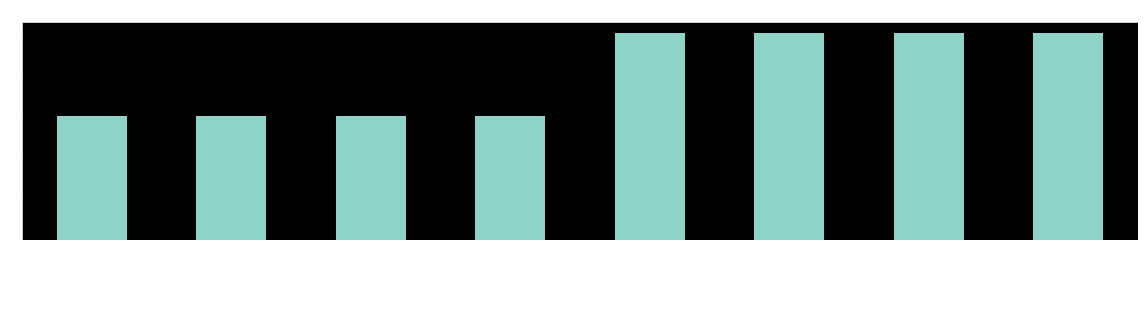

In [6]:

if label_orientation == "posinega":
    if tgt == 'ja':
        positive_label_LIWC = '.*Joy|Trust.*'
        negative_label_LIWC = '.*Sadness|Disgust.*'
    elif tgt == 'zh':
        positive_label_LIWC = '.*posemo.*'
        negative_label_LIWC = '.*negemo.*'
else:
    pass
    
label_diff = pd.DataFrame()
# print(len(result.index))
label_diff = result[result['MT_original label'] != result['HT_original label']]
# print(len(label_diff.index))
label_same = pd.DataFrame()
label_same['MT_original label']           = label_diff['MT_original label'] == label_diff['MT_original label']
label_same['MT_added_clause_front label'] = label_diff['MT_original label'] == label_diff['MT_added_clause_front label']
label_same['MT_added_clause_back label']  = label_diff['MT_original label'] == label_diff['MT_added_clause_back label']
label_same['MT_added_word_front label']   = label_diff['MT_original label'] == label_diff['MT_added_word_front label']
label_same['MT_added_word_back label']    = label_diff['MT_original label'] == label_diff['MT_added_word_back label']
label_same['HT_original label']           = label_diff['HT_original label'] == label_diff['HT_original label']
label_same['HT_removed_clause label']     = label_diff['HT_original label'] == label_diff['HT_removed_clause label']
label_same['HT_removed_word label']       = label_diff['HT_original label'] == label_diff['HT_removed_word label']
plt.style.use('dark_background')
print('[LIWC:all] count of different output label')
display(label_same.sort_index(ascending=False,axis=1).describe().T.sort_values(ascending=True,by='freq'))
label_same.sort_index(ascending=False,axis=1).describe().T.sort_values(ascending=True,by='freq')['freq'].plot.bar(figsize=(20,4),title='[LIWC:all] count of diff label output label',fontsize='x-large',rot=15)

[LIWC:posi] count of different output label


,count,unique,top,freq
MT_added_clause_back label,2,2,True,1
MT_added_word_back label,2,2,True,1
HT_removed_clause label,2,2,True,1
HT_removed_word label,2,2,True,1
MT_original label,2,1,True,2
MT_added_clause_front label,2,1,True,2
MT_added_word_front label,2,1,True,2
HT_original label,2,1,True,2


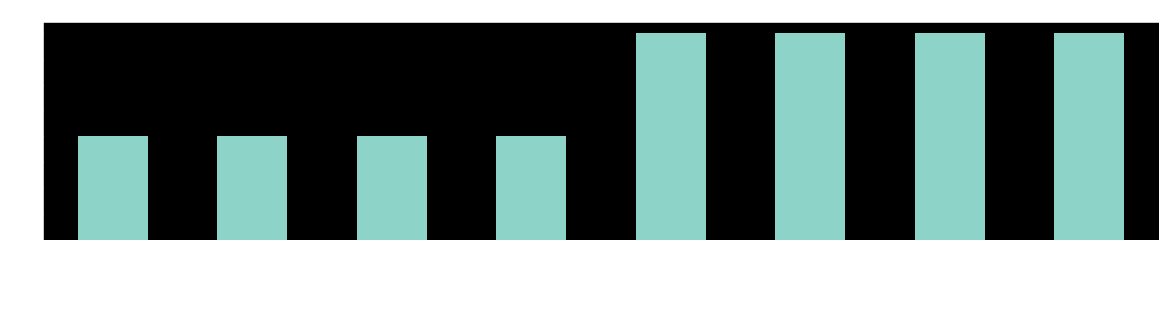

In [7]:
print('[LIWC:posi] count of different output label')
display(label_same.filter(regex=positive_label_LIWC,axis=0).describe().T.sort_values(ascending=True,by='freq'))
label_same.filter(regex=positive_label_LIWC,axis=0).describe().T.sort_values(ascending=True,by='freq')['freq'].plot.bar(figsize=(20,4),title='[LIWC:posi] count of diff label output label',fontsize='x-large',rot=15)

[LIWC:nega] count of different output label


,count,unique,top,freq
MT_original label,0,0,NaN,NaN
MT_added_clause_front label,0,0,NaN,NaN
MT_added_clause_back label,0,0,NaN,NaN
MT_added_word_front label,0,0,NaN,NaN
MT_added_word_back label,0,0,NaN,NaN
HT_original label,0,0,NaN,NaN
HT_removed_clause label,0,0,NaN,NaN
HT_removed_word label,0,0,NaN,NaN


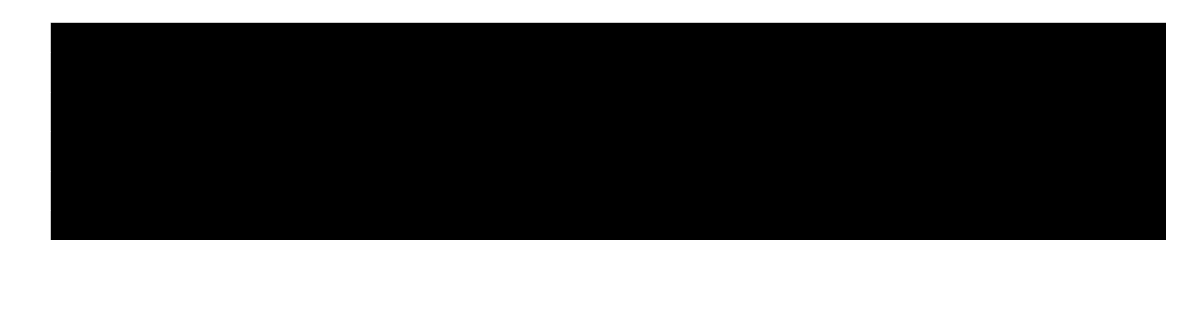

In [8]:
print('[LIWC:nega] count of different output label')
display(label_same.filter(regex=negative_label_LIWC,axis=0).describe().T.sort_values(ascending=True,by='freq'))
label_same.filter(regex=negative_label_LIWC,axis=0).describe().T.sort_values(ascending=True,by='freq')['freq'].plot.bar(figsize=(20,4),title='[LIWC:nega] count of diff label output labellabel_same',fontsize='x-large',rot=15)

# 加加減減 unaligned-emotion-word or clause的結果
# MT-HT之間的output probability的差異有多少差別？
## diff btw MT-HT prob
數值越小，MT-HT越變相似了

[ClassifierOutput:posi, LIWC:all] diff btw MT-HT on prob of posi-label sorted by mean


,count,mean,std,min,25%,50%,75%,max
Add Clause back posi,77.0,0.532481,0.726514,0.004942,0.237584,0.333930,0.535658,4.276185
Add Word Back posi,77.0,0.665301,0.742287,0.065458,0.246713,0.490410,0.773655,3.713663
Add Word Front posi,77.0,0.699530,0.727214,0.033780,0.255892,0.529052,0.827007,4.512569
Rmv Word posi,77.0,0.713288,0.844079,0.020390,0.204230,0.522541,0.746937,5.118967
Rmv Clause posi,77.0,0.714938,0.897029,0.070197,0.218274,0.326721,0.761889,4.919019
Add Clause Front posi,77.0,0.726246,0.737874,0.035434,0.272319,0.488456,0.741740,4.194843
Original posi,77.0,0.760186,1.006358,0.037051,0.123073,0.485059,0.808200,4.296391


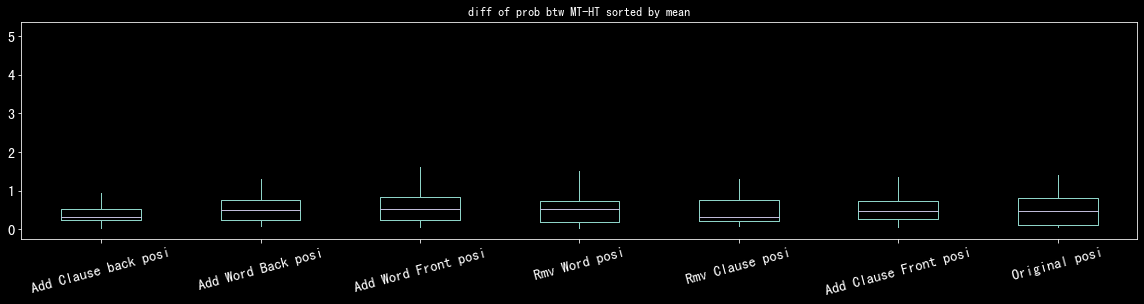

In [9]:

diff_df = pd.DataFrame()
diff_df['Original posi'] =         result['MT_original posi']           - result['HT_original posi']
diff_df['Add Clause Front posi'] = result['MT_added_clause_front posi'] - result['HT_original posi']
diff_df['Add Clause back posi'] =  result['MT_added_clause_back posi']  - result['HT_original posi']
diff_df['Rmv Clause posi'] =       result['MT_original posi']           - result['HT_removed_clause posi']
diff_df['Add Word Front posi'] =   result['MT_added_word_front posi']   - result['HT_original posi']
diff_df['Add Word Back posi'] =    result['MT_added_word_back posi']    - result['HT_original posi']
diff_df['Rmv Word posi'] =         result['MT_original posi']           - result['HT_removed_word posi']
diff_df['Original nega'] =         result['MT_original nega']           - result['HT_original nega']
diff_df['Add Clause Front nega'] = result['MT_added_clause_front nega'] - result['HT_original nega']
diff_df['Add Clause back nega'] =  result['MT_added_clause_back nega']  - result['HT_original nega']
diff_df['Rmv Clause nega'] =       result['MT_original nega']           - result['HT_removed_clause nega']
diff_df['Add Word Front nega'] =   result['MT_added_word_front nega']   - result['HT_original nega']
diff_df['Add Word Back nega'] =    result['MT_added_word_back nega']    - result['HT_original nega']
diff_df['Rmv Word nega'] =         result['MT_original nega']           - result['HT_removed_word nega']
diff_df = diff_df.abs()
plt.style.use('dark_background')
# diff_df.plot.box(figsize=(20,6),fontsize='x-large',rot=15)
print('[ClassifierOutput:posi, LIWC:all] diff btw MT-HT on prob of posi-label sorted by mean')
display(diff_df.filter(like="posi").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(like="posi").plot.box(figsize=(20,4),title='diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)


[ClassifierOutput:nega, LIWC:all] diff btw MT-HT on prob of nega-label sorted by mean


,count,mean,std,min,25%,50%,75%,max
Add Clause back nega,77.0,0.660923,0.760946,0.009254,0.229095,0.491905,0.751007,4.261561
Add Word Front nega,77.0,0.730240,0.687541,0.026293,0.263041,0.539506,0.955807,4.071044
Add Clause Front nega,77.0,0.770736,0.764248,0.006289,0.311901,0.557514,1.008632,3.664997
Rmv Clause nega,77.0,0.800861,0.776517,0.044313,0.314188,0.637278,0.866463,4.790489
Add Word Back nega,77.0,0.813220,0.764480,0.054801,0.338735,0.712689,0.907953,4.168645
Original nega,77.0,0.884037,0.899149,0.012994,0.370701,0.591962,1.077041,4.037413
Rmv Word nega,77.0,0.888525,0.770982,0.004747,0.421196,0.811332,1.041077,4.726639


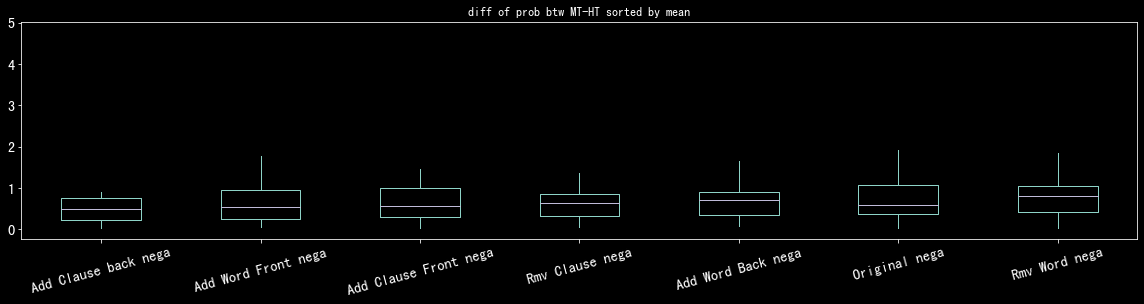

In [10]:
print('[ClassifierOutput:nega, LIWC:all] diff btw MT-HT on prob of nega-label sorted by mean')
display(diff_df.filter(like="nega").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(like="nega").plot.box(figsize=(20,4),title = 'diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

[ClassifierOutput:posi, LIWC:posi] diff btw MT-HT on prob of posi-label sorted by mean


,count,mean,std,min,25%,50%,75%,max
Add Clause back posi,14.0,0.732941,1.097783,0.004942,0.236275,0.392693,0.786318,4.276185
Rmv Word posi,14.0,0.749643,0.902739,0.020390,0.194284,0.472576,0.812703,3.451040
Rmv Clause posi,14.0,0.749810,0.963883,0.070197,0.192796,0.278294,1.053927,3.308709
Add Word Front posi,14.0,0.820459,0.711467,0.104742,0.352104,0.720286,1.007405,2.767069
Add Word Back posi,14.0,0.840410,0.883780,0.066223,0.433523,0.637757,0.882739,3.713663
Add Clause Front posi,14.0,0.948455,0.867244,0.035434,0.398905,0.603571,1.474511,3.123503
Original posi,14.0,1.081763,1.325925,0.067732,0.448786,0.706065,0.942832,4.296391


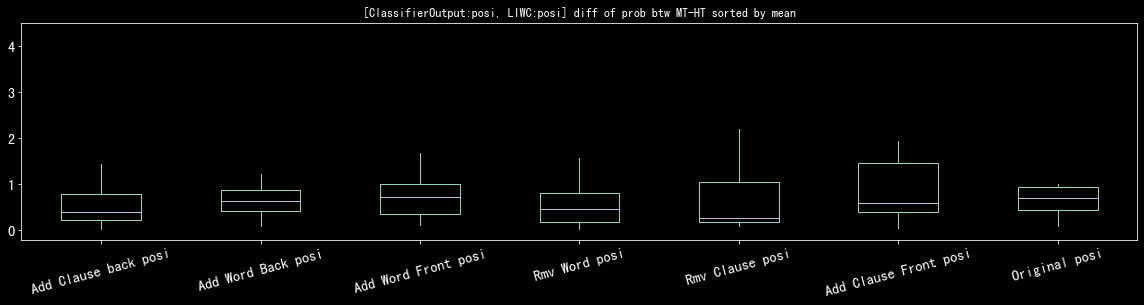

In [11]:
print('[ClassifierOutput:posi, LIWC:posi] diff btw MT-HT on prob of posi-label sorted by mean')
display(diff_df.filter(regex=positive_label_LIWC,axis=0).filter(like="posi").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(regex=positive_label_LIWC,axis=0).filter(like="posi").plot.box(figsize=(20,4),title='[ClassifierOutput:posi, LIWC:posi] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

[ClassifierOutput:posi, LIWC:nega] diff btw MT-HT on prob of nega-label sorted by mean


,count,mean,std,min,25%,50%,75%,max
Add Clause back posi,22.0,0.423246,0.378720,0.030673,0.245824,0.333920,0.497651,1.772778
Add Clause Front posi,22.0,0.568289,0.437485,0.128791,0.274690,0.472049,0.670990,2.109839
Add Word Back posi,22.0,0.579927,0.612277,0.065458,0.164775,0.343691,0.733639,2.335706
Original posi,22.0,0.601881,0.635094,0.037051,0.098830,0.380468,0.749655,2.333384
Add Word Front posi,22.0,0.605955,0.583811,0.033780,0.239843,0.482058,0.665315,2.578030
Rmv Clause posi,22.0,0.702964,0.742739,0.125098,0.249500,0.377393,1.033157,2.859397
Rmv Word posi,22.0,0.707299,0.657333,0.022207,0.336864,0.544251,0.911632,2.594519


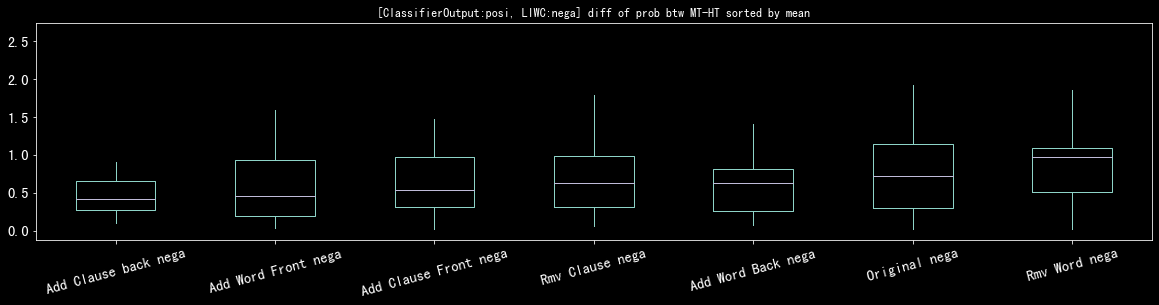

In [12]:
print('[ClassifierOutput:posi, LIWC:nega] diff btw MT-HT on prob of nega-label sorted by mean')
display(diff_df.filter(regex=negative_label_LIWC,axis=0).filter(like="posi").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(regex=negative_label_LIWC,axis=0).filter(like="nega").plot.box(figsize=(20,4),title = '[ClassifierOutput:posi, LIWC:nega] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

[ClassifierOutput:nega, LIWC:posi] diff btw MT-HT on prob of posi-label sorted by mean


,count,mean,std,min,25%,50%,75%,max
Add Word Front nega,14.0,0.812471,0.682164,0.067109,0.330198,0.611044,1.321753,2.264354
Rmv Clause nega,14.0,0.817751,0.708149,0.080498,0.396083,0.732479,0.845268,2.430051
Rmv Word nega,14.0,0.861775,0.876845,0.005216,0.408300,0.675194,0.953241,3.567283
Add Clause back nega,14.0,0.884748,1.160926,0.009254,0.118643,0.540949,1.367401,4.261561
Add Clause Front nega,14.0,0.916126,0.973827,0.080575,0.147883,0.488073,1.178790,2.759228
Add Word Back nega,14.0,0.987610,0.848196,0.240278,0.420716,0.752965,1.071249,3.489673
Original nega,14.0,0.998606,1.167112,0.140297,0.464046,0.575633,0.774562,4.037413


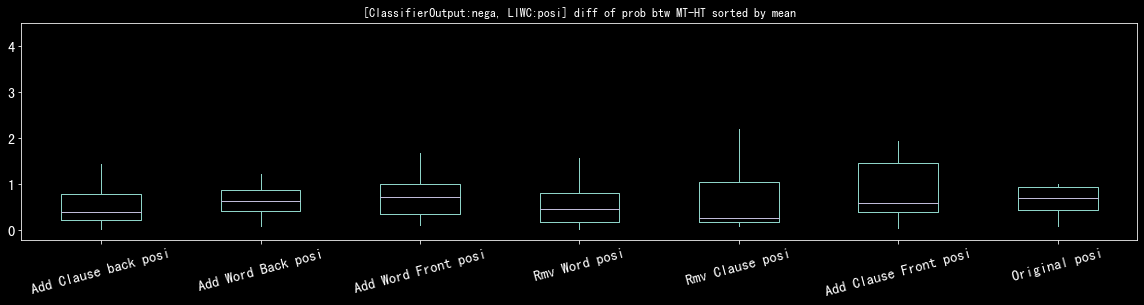

In [13]:
print('[ClassifierOutput:nega, LIWC:posi] diff btw MT-HT on prob of posi-label sorted by mean')
display(diff_df.filter(regex=positive_label_LIWC,axis=0).filter(like="nega").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(regex=positive_label_LIWC,axis=0).filter(like="posi").plot.box(figsize=(20,4),title='[ClassifierOutput:nega, LIWC:posi] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

[ClassifierOutput:nega, LIWC:nega] diff btw MT-HT on prob of nega-label sorted by mean


,count,mean,std,min,25%,50%,75%,max
Add Clause back nega,22.0,0.504794,0.396451,0.090680,0.267252,0.420030,0.654508,1.968013
Add Word Front nega,22.0,0.634110,0.587022,0.026293,0.190602,0.457502,0.936824,2.450625
Add Clause Front nega,22.0,0.670994,0.539138,0.006289,0.317460,0.535990,0.965843,2.333865
Add Word Back nega,22.0,0.700626,0.581221,0.054801,0.252323,0.630691,0.819546,2.122660
Rmv Clause nega,22.0,0.762619,0.644212,0.044313,0.314188,0.624384,0.985353,2.617243
Original nega,22.0,0.825956,0.631768,0.012994,0.293717,0.721384,1.147680,1.935779
Rmv Word nega,22.0,0.870123,0.501952,0.004747,0.515265,0.975271,1.090247,1.867996


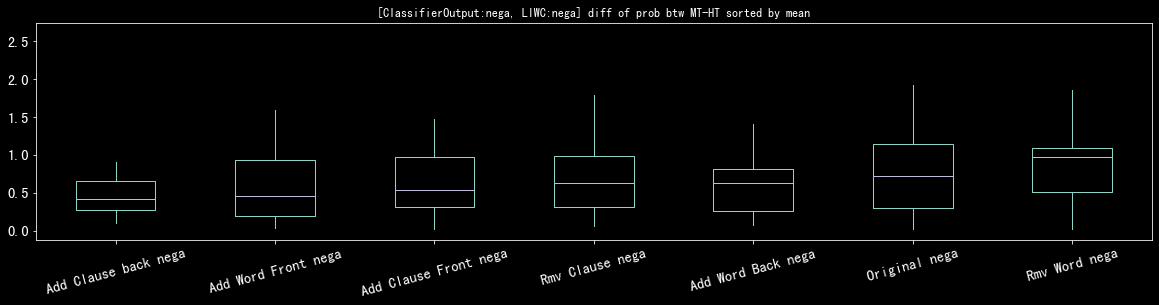

In [14]:
print('[ClassifierOutput:nega, LIWC:nega] diff btw MT-HT on prob of nega-label sorted by mean')
display(diff_df.filter(regex=negative_label_LIWC,axis=0).filter(like="nega").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(regex=negative_label_LIWC,axis=0).filter(like="nega").plot.box(figsize=(20,4),title = '[ClassifierOutput:nega, LIWC:nega] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

## diff btw MT-HT prob （posi+nega） 

[ClassifierOutput:posi+nega, LIWC:all]


,count,mean,std,min,25%,50%,75%,max
Add Clause back posi+nega,77.0,1.193403,1.453020,0.042635,0.568884,0.817809,1.195395,8.537745
Add Word Front posi+nega,77.0,1.429770,1.345947,0.236284,0.555344,1.092835,1.696209,8.583613
Add Word Back posi+nega,77.0,1.478521,1.467284,0.200721,0.611559,1.093308,1.567590,7.502186
Add Clause Front posi+nega,77.0,1.496982,1.451009,0.295762,0.592947,1.001309,1.693233,7.859841
Rmv Clause posi+nega,77.0,1.515799,1.601332,0.281209,0.615749,0.952509,1.636935,9.709508
Rmv Word posi+nega,77.0,1.601813,1.553863,0.196185,0.753371,1.255301,1.781188,9.845606
Original posi+nega,77.0,1.644223,1.857651,0.160453,0.635469,1.099233,1.562317,8.333804


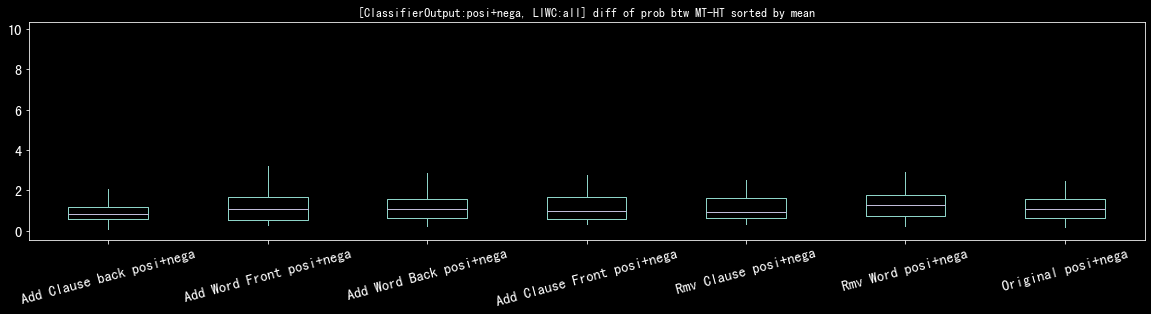

In [15]:
diff_df['Original posi+nega']         = diff_df['Original posi'] + diff_df['Original nega'] 
diff_df['Add Clause Front posi+nega'] = diff_df['Add Clause Front posi'] + diff_df['Add Clause Front nega'] 
diff_df['Add Clause back posi+nega']  = diff_df['Add Clause back posi'] + diff_df['Add Clause back nega']
diff_df['Rmv Clause posi+nega']       = diff_df['Rmv Clause posi']  + diff_df['Rmv Clause nega'] 
diff_df['Add Word Front posi+nega']   = diff_df['Add Word Front posi'] + diff_df['Add Word Front nega'] 
diff_df['Add Word Back posi+nega']    = diff_df['Add Word Back posi'] + diff_df['Add Word Back nega']
diff_df['Rmv Word posi+nega']         = diff_df['Rmv Word posi'] + diff_df['Rmv Word nega'] 

print('[ClassifierOutput:posi+nega, LIWC:all]')
display(diff_df.filter(like="posi+nega").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(like="posi+nega").plot.box(figsize=(20,4),title='[ClassifierOutput:posi+nega, LIWC:all] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)


[ClassifierOutput:posi+nega, LIWC:posi]


,count,mean,std,min,25%,50%,75%,max
Rmv Clause posi+nega,14.0,1.567561,1.612992,0.287263,0.733375,0.924324,1.838915,5.624045
Rmv Word posi+nega,14.0,1.611418,1.746168,0.196185,0.669706,1.053546,1.738088,7.018323
Add Clause back posi+nega,14.0,1.617689,2.220104,0.042635,0.400801,0.929502,1.859333,8.537745
Add Word Front posi+nega,14.0,1.632929,1.242319,0.280387,0.996518,1.302061,1.856724,4.572751
Add Word Back posi+nega,14.0,1.828020,1.692196,0.331683,0.993678,1.455361,1.690799,7.203336
Add Clause Front posi+nega,14.0,1.864581,1.768926,0.295762,0.596332,1.049696,2.598287,5.746547
Original posi+nega,14.0,2.080369,2.474304,0.208029,0.917429,1.237226,1.540967,8.333804


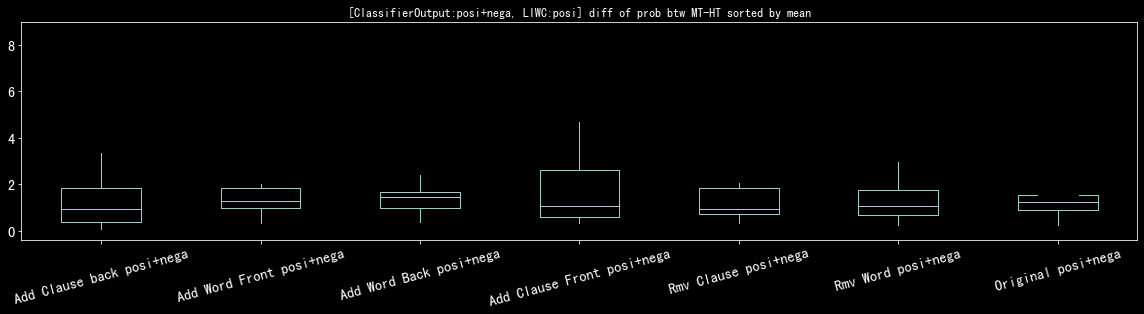

In [16]:
print('[ClassifierOutput:posi+nega, LIWC:posi]')
display(diff_df.filter(regex=positive_label_LIWC,axis=0).filter(like="posi+nega").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(regex=positive_label_LIWC,axis=0).filter(like="posi+nega").plot.box(figsize=(20,4),title='[ClassifierOutput:posi+nega, LIWC:posi] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

[ClassifierOutput:posi+nega, LIWC:nega]


,count,mean,std,min,25%,50%,75%,max
Add Clause back posi+nega,22.0,0.928041,0.731775,0.307962,0.586519,0.697149,1.148476,3.740791
Add Clause Front posi+nega,22.0,1.239283,0.935709,0.377635,0.586537,1.001626,1.535823,4.443704
Add Word Front posi+nega,22.0,1.240065,1.135880,0.236284,0.448621,0.898118,1.617868,5.028655
Add Word Back posi+nega,22.0,1.280553,1.148751,0.200721,0.526529,0.916534,1.308797,4.458366
Original posi+nega,22.0,1.427837,1.173349,0.160453,0.628197,1.048119,2.073661,4.203532
Rmv Clause posi+nega,22.0,1.465583,1.276145,0.281209,0.615749,1.187769,1.713336,4.657842
Rmv Word posi+nega,22.0,1.577422,1.024721,0.223609,0.856458,1.357739,2.029148,4.091035


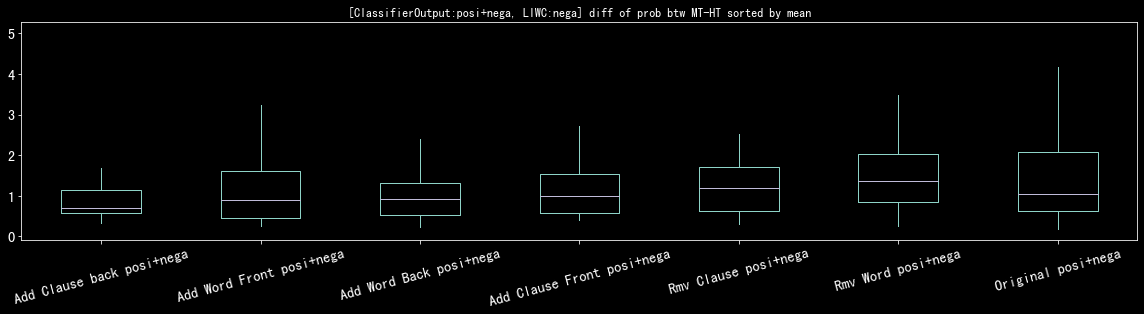

In [17]:
print('[ClassifierOutput:posi+nega, LIWC:nega]')
display(diff_df.filter(regex=negative_label_LIWC,axis=0).filter(like="posi+nega").describe().T.sort_values(ascending=True,by='mean'))
diff_df[diff_df.describe().T.sort_values(ascending=True,by='mean').index].filter(regex=negative_label_LIWC,axis=0).filter(like="posi+nega").plot.box(figsize=(20,4),title='[ClassifierOutput:posi+nega, LIWC:nega] diff of prob btw MT-HT sorted by mean',fontsize='x-large',rot=15)

## count of instance which less diff btw MT-HT prob
數值越大，變比較像的越多

[ClassifierOutput:posi, LIWC:all] count of smaller diff prob
# of diff: 77


Add Clause back posi     43
Add Word Back posi       42
Rmv Word posi            41
Rmv Clause posi          40
Add Clause Front posi    36
Add Word Front posi      30
dtype: int64

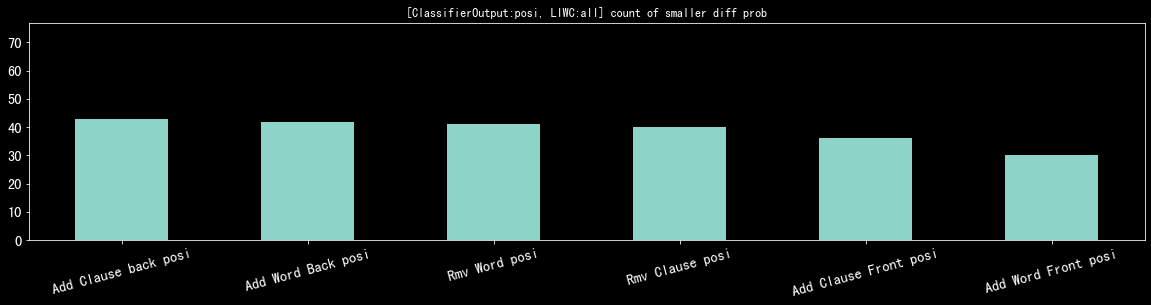

In [18]:
smaller_count = pd.DataFrame()
smaller_count['Add Clause Front posi'] = diff_df['Add Clause Front posi'] < diff_df['Original posi']
smaller_count['Add Clause back posi'] =  diff_df['Add Clause back posi']  < diff_df['Original posi']
smaller_count['Rmv Clause posi'] =       diff_df['Rmv Clause posi']       < diff_df['Original posi']
smaller_count['Add Word Front posi'] =   diff_df['Add Word Front posi']   < diff_df['Original posi']
smaller_count['Add Word Back posi'] =    diff_df['Add Word Back posi']    < diff_df['Original posi']
smaller_count['Rmv Word posi'] =         diff_df['Rmv Word posi']         < diff_df['Original posi']
smaller_count['Add Clause Front nega'] = diff_df['Add Clause Front nega'] < diff_df['Original nega']
smaller_count['Add Clause back nega'] =  diff_df['Add Clause back nega']  < diff_df['Original nega']
smaller_count['Rmv Clause nega'] =       diff_df['Rmv Clause nega']       < diff_df['Original nega']
smaller_count['Add Word Front nega'] =   diff_df['Add Word Front nega']   < diff_df['Original nega']
smaller_count['Add Word Back nega'] =    diff_df['Add Word Back nega']    < diff_df['Original nega']
smaller_count['Rmv Word nega'] =         diff_df['Rmv Word nega']         < diff_df['Original nega']

print('[ClassifierOutput:posi, LIWC:all] count of smaller diff prob')
n = diff_df.count()[0]
print('# of diff:', n)
display((smaller_count.filter(like="posi")).sum().sort_values(ascending=False))
(smaller_count.filter(like="posi")).sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:posi, LIWC:all] count of smaller diff prob',fontsize='x-large',rot=15)

# print('[ClassifierOutput:all, LIWC:all] count of smaller diff prob')
# display((smaller_count == True).sum().sort_values(ascending=False))
# (smaller_count == True).sum().sort_values(ascending=False).plot.bar(figsize=(20,6),ylim=(0,n),title='[ClassifierOutput:all, LIWC:all] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:nega, LIWC:all] count of smaller diff prob
# of diff: 77


Add Clause Front nega    51
Add Clause back nega     48
Add Word Front nega      46
Add Word Back nega       43
Rmv Clause nega          34
Rmv Word nega            32
dtype: int64

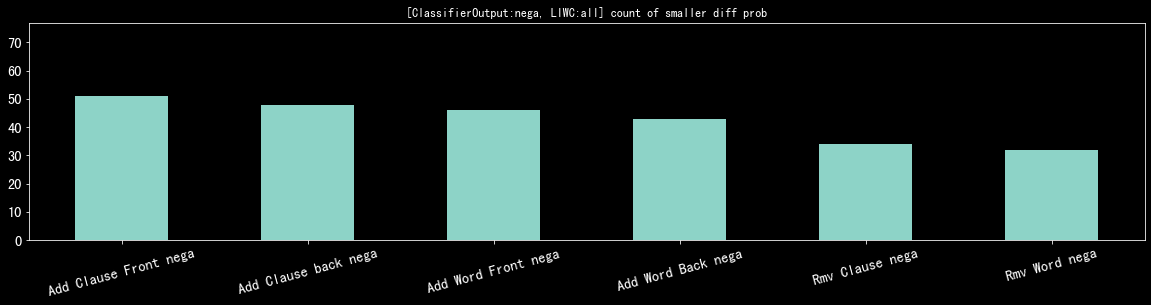

In [19]:
print('[ClassifierOutput:nega, LIWC:all] count of smaller diff prob')
n = diff_df.count()[0]
print('# of diff:', n)
display((smaller_count.filter(like="nega")).sum().sort_values(ascending=False))
(smaller_count.filter(like="nega")).sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:nega, LIWC:all] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:posi, LIWC:posi] count of smaller diff prob
# of diff: 14


Add Clause back posi     10
Rmv Word posi             9
Rmv Clause posi           9
Add Word Front posi       8
Add Clause Front posi     8
Add Word Back posi        7
dtype: int64

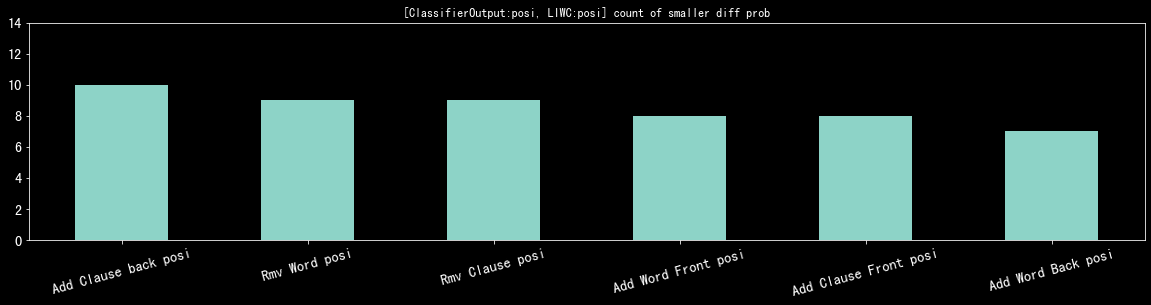

In [20]:
print('[ClassifierOutput:posi, LIWC:posi] count of smaller diff prob')
n = diff_df.filter(regex=positive_label_LIWC,axis=0).count()[0]
print('# of diff:',n)
display((smaller_count.filter(regex=positive_label_LIWC,axis=0).filter(like="posi")).sum().sort_values(ascending=False))
smaller_count.filter(regex=positive_label_LIWC,axis=0).filter(like="posi").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:posi, LIWC:posi] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:posi, LIWC:nega] count of smaller diff prob
# of diff: 22


Add Word Back posi       13
Add Clause back posi     12
Rmv Clause posi          11
Rmv Word posi            10
Add Clause Front posi     9
Add Word Front posi       6
dtype: int64

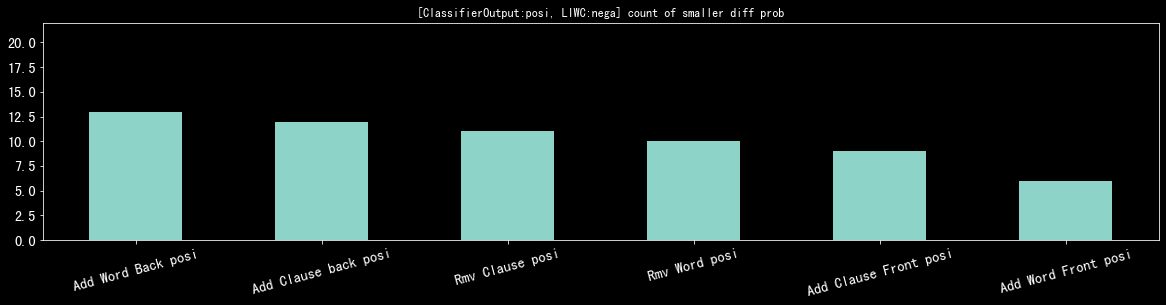

In [21]:
print('[ClassifierOutput:posi, LIWC:nega] count of smaller diff prob')
n = diff_df.filter(regex=negative_label_LIWC,axis=0).count()[0]
print('# of diff:',n)
display(smaller_count.filter(regex=negative_label_LIWC,axis=0).filter(like="posi").sum().sort_values(ascending=False))
smaller_count.filter(regex=negative_label_LIWC,axis=0).filter(like="posi").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:posi, LIWC:nega] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:nega, LIWC:posi] count of smaller diff prob
# of diff: 14


Add Clause Front nega    10
Add Clause back nega      9
Rmv Clause nega           8
Add Word Front nega       7
Rmv Word nega             6
Add Word Back nega        6
dtype: int64

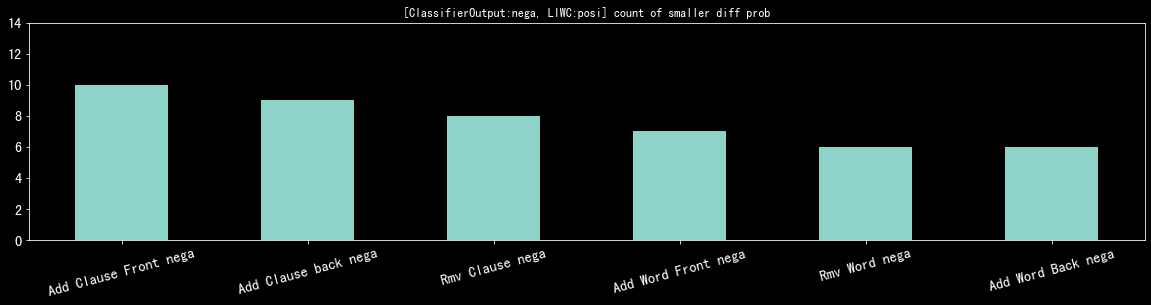

In [22]:
print('[ClassifierOutput:nega, LIWC:posi] count of smaller diff prob')
n = diff_df.filter(regex=positive_label_LIWC,axis=0).count()[0]
print('# of diff:',n)
display((smaller_count.filter(regex=positive_label_LIWC,axis=0).filter(like="nega")).sum().sort_values(ascending=False))
smaller_count.filter(regex=positive_label_LIWC,axis=0).filter(like="nega").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:nega, LIWC:posi] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:nega, LIWC:nega] count of smaller diff prob
# of diff: 22


Add Word Front nega      15
Add Word Back nega       14
Add Clause back nega     14
Add Clause Front nega    14
Rmv Word nega            10
Rmv Clause nega           9
dtype: int64

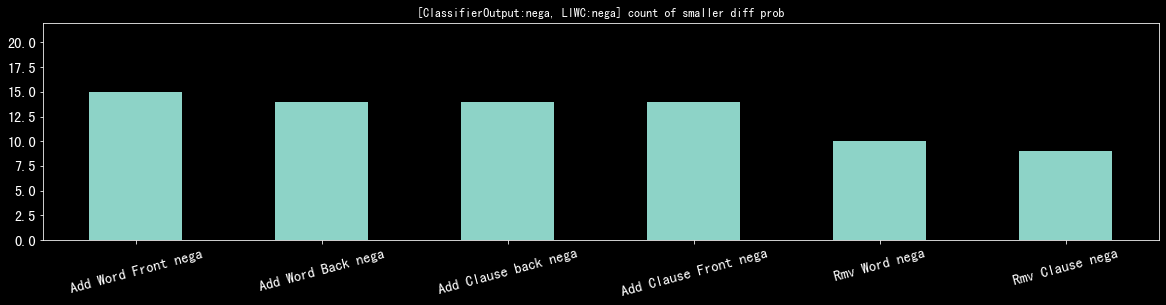

In [23]:
print('[ClassifierOutput:nega, LIWC:nega] count of smaller diff prob')
n = diff_df.filter(regex=negative_label_LIWC,axis=0).count()[0]
print('# of diff:',n)
display(smaller_count.filter(regex=negative_label_LIWC,axis=0).filter(like="nega").sum().sort_values(ascending=False))
smaller_count.filter(regex=negative_label_LIWC,axis=0).filter(like="nega").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:nega, LIWC:nega] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:posi+nega, LIWC:all] count of smaller diff prob
# of diff: 77


Add Clause back posi+nega     49
Add Clause Front posi+nega    43
Rmv Clause posi+nega          39
Rmv Word posi+nega            38
Add Word Front posi+nega      38
Add Word Back posi+nega       36
dtype: int64

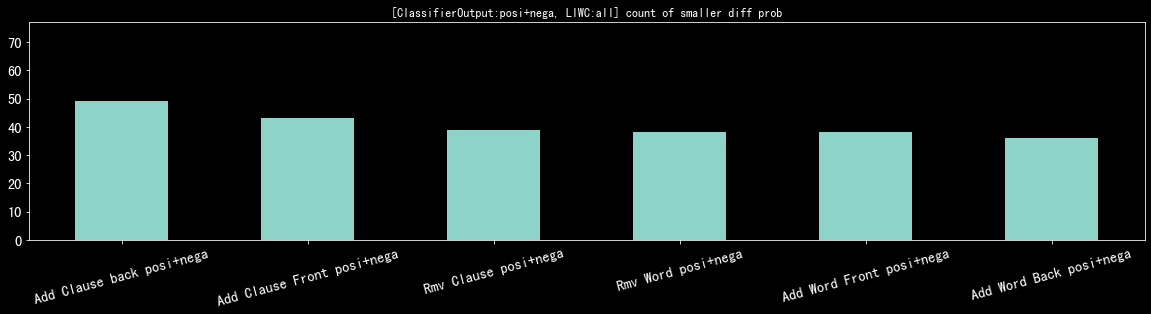

In [24]:
smaller_count['Add Clause Front posi+nega'] = diff_df['Add Clause Front posi+nega'] < diff_df['Original posi+nega']
smaller_count['Add Clause back posi+nega'] =  diff_df['Add Clause back posi+nega']  < diff_df['Original posi+nega']
smaller_count['Rmv Clause posi+nega'] =       diff_df['Rmv Clause posi+nega']       < diff_df['Original posi+nega']
smaller_count['Add Word Front posi+nega'] =   diff_df['Add Word Front posi+nega']   < diff_df['Original posi+nega']
smaller_count['Add Word Back posi+nega'] =    diff_df['Add Word Back posi+nega']    < diff_df['Original posi+nega']
smaller_count['Rmv Word posi+nega'] =         diff_df['Rmv Word posi+nega']         < diff_df['Original posi+nega']

print('[ClassifierOutput:posi+nega, LIWC:all] count of smaller diff prob')
n = diff_df.count()[0]
print('# of diff:',n)
display((smaller_count.filter(like="posi+nega")).sum().sort_values(ascending=False))
smaller_count.filter(like="posi+nega").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:posi+nega, LIWC:all] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:posi+nega, LIWC:posi] count of smaller diff prob
# of diff: 14


Rmv Clause posi+nega          9
Add Clause back posi+nega     9
Add Clause Front posi+nega    9
Rmv Word posi+nega            8
Add Word Front posi+nega      8
Add Word Back posi+nega       5
dtype: int64

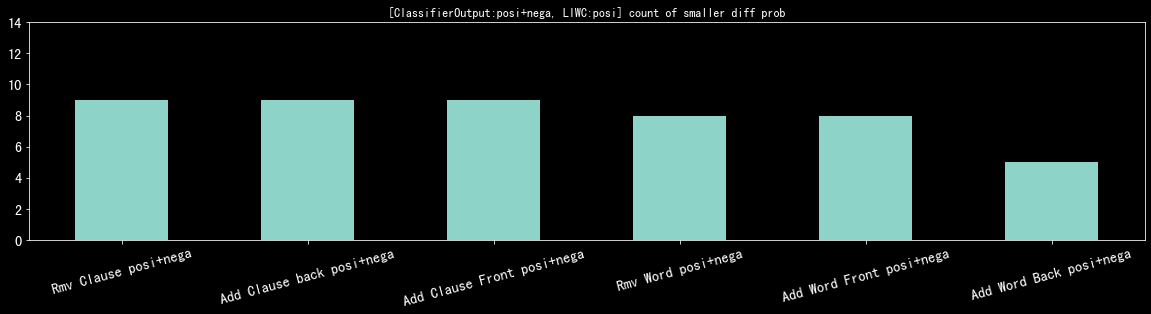

In [25]:
print('[ClassifierOutput:posi+nega, LIWC:posi] count of smaller diff prob')
n = diff_df.filter(regex=positive_label_LIWC,axis=0).count()[0]
print('# of diff:',n)
display((smaller_count.filter(regex=positive_label_LIWC,axis=0).filter(like="posi+nega")).sum().sort_values(ascending=False))
smaller_count.filter(regex=positive_label_LIWC,axis=0).filter(like="posi+nega").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:posi+nega, LIWC:posi] count of smaller diff prob',fontsize='x-large',rot=15)

[ClassifierOutput:posi+nega, LIWC:nega] count of smaller diff prob
# of diff: 22


Add Clause back posi+nega     15
Add Word Back posi+nega       12
Rmv Word posi+nega            11
Add Clause Front posi+nega    11
Add Word Front posi+nega      10
Rmv Clause posi+nega          10
dtype: int64

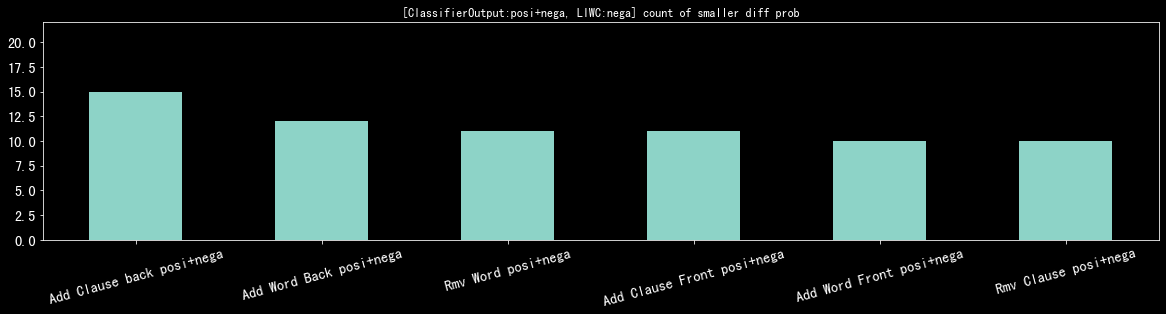

In [26]:
print('[ClassifierOutput:posi+nega, LIWC:nega] count of smaller diff prob')
n = diff_df.filter(regex=negative_label_LIWC,axis=0).count()[0]
print('# of diff:',n)
display(smaller_count.filter(regex=negative_label_LIWC,axis=0).filter(like="posi+nega").sum().sort_values(ascending=False))
smaller_count.filter(regex=negative_label_LIWC,axis=0).filter(like="posi+nega").sum().sort_values(ascending=False).plot.bar(figsize=(20,4),ylim=(0,n),title='[ClassifierOutput:posi+nega, LIWC:nega] count of smaller diff prob',fontsize='x-large',rot=15)

# 顯示句子

In [45]:
smaller_count[smaller_count['Add Clause back posi+nega']==True]['Add Clause back posi+nega']

add cejc query apology affect 35 不      True
add cejc query apology affect 37 不      True
add cejc query apology affect 68 不      True
add cejc query apology affect 202 不     True
add cejc query apology affect 35 不小心    True
add cejc query apology affect 10 可以     True
add cejc query apology affect 12 可以     True
add cejc query apology affect 125 可以    True
add cejc query apology affect 132 可以    True
add cejc query apology affect 87 喜欢     True
add cejc query apology affect 7 好       True
add cejc query apology affect 155 好     True
add cejc query apology affect 217 好     True
add cejc query apology affect 313 好吃    True
add cejc query apology affect 258 对     True
add cejc query apology affect 258 想     True
add cejc query apology affect 9 抱歉      True
add cejc query apology affect 44 麻烦     True
add cejc query apology affect 86 麻烦     True
add cejc query apology affect 99 麻烦     True
add cejc query apology affect 149 麻烦    True
add cejc query apology affect 191 麻烦    True
add cejc q

In [44]:
index = smaller_count[smaller_count['Add Clause back posi+nega']==True]['Add Clause back posi+nega'].index
index.to_list()
index_list = []
for i in index:
    index_list.append(i.split(' ')[:7])
# index_list

In [42]:

columns_name=['diff_type','corpus','situation','sen_type','emotion','word','htmt','line','part','effect','direct','intence','perspective']
df = pd.read_csv(labeled_table_path, names=columns_name)
# REPLACE subordinate concept to MOREorLESS intencity
more =   ['lessdowngrader','moreupgrader','morespecific','lessrespectful','lesshumble','add_expect_sth_in_return','add_irony']
less = ['moredowngrader','lessspecific','lessupgrader','morerespectful','morehumble','rmv_expect_sth_in_return','rmv_irony']

for m, l in zip(more, less):
    df=df.replace(m,'moreintence')
    df=df.replace(l,'lessintence')

index_names=[]
all_sentiment_table=[]
for s in sig_list:
    diff_type=s[0]
    corpus=s[1]
    sen_type=s[2]
    situation=s[3]
    emotion=s[4]
    # FILTER TABLE
    emo_cond = df['diff_type'].isin([diff_type]) & df['corpus'].isin([corpus]) & df['sen_type'].isin([sen_type]) & df['situation'].isin([situation]) & df['emotion'].isin([emotion])
    gizamiss_cond = df['part'].isin(['gizamiss','labelmiss'])
    line = df[emo_cond&~gizamiss_cond]['line'].to_list()
    word = df[emo_cond&~gizamiss_cond]['word'].to_list()
    # GET DATA
    if tgt == 'ja':
        MT_path = f'../data/mpdd/{situation}/translated_{sen_type}.csv'
        HT_path = f'../data/mpdd/{situation}/rewrited_{sen_type}.csv'
        MT_mrph_path = f'../mrphdata/mpdd/{situation}/translated_{sen_type}'
        HT_mrph_path = f'../mrphdata/mpdd/{situation}/rewrited_{sen_type}'
        MT_unaligned_path = f'../analysis/unaligned_index/mpdd/{situation}/translated_{sen_type}.{diff_type}'
        HT_unaligned_path = f'../analysis/unaligned_index/mpdd/{situation}/rewrited_{sen_type}.{diff_type}'
    elif tgt == 'zh':
        MT_path = f'../data/cejc/{situation}/translated_{sen_type}.csv'
        HT_path = f'../data/cejc/{situation}/rewrited_{sen_type}.csv'
        MT_mrph_path = f'../mrphdata/cejc/{situation}/translated_{sen_type}'
        HT_mrph_path = f'../mrphdata/cejc/{situation}/rewrited_{sen_type}'
        MT_unaligned_path = f'../analysis/unaligned_index/cejc/{situation}/translated_{sen_type}.{diff_type}'
        HT_unaligned_path = f'../analysis/unaligned_index/cejc/{situation}/rewrited_{sen_type}.{diff_type}'
    
    MT_data = get_data_as_list(MT_path)
    HT_data = get_data_as_list(HT_path)
    MT_unaligned = get_mrphdata_as_list(MT_unaligned_path)
    HT_unaligned = get_mrphdata_as_list(HT_unaligned_path)
    MT_mrph = get_mrphdata_as_list(MT_mrph_path)
    HT_mrph = get_mrphdata_as_list(HT_mrph_path)
    sentiment_table = []
    for l,w in zip(line,word):
        # GET CLAUSE WHICH HAS UNALIGNED WORD
        clause = get_clause(HT_unaligned[l],HT_mrph[l])
#         print('clause: ',clause) 
#         print('word:   ',w)
        # ADD THE CLAUSE TO MT-SENTENCE
        # 一番前に追加 
        sen = MT_mrph[l]
        for c in clause: 
            sen = c + sen
        MT_added_clause_front = ''.join(sen)
        # 一番後ろに追加 
        sen = MT_mrph[l]
        for c in clause: 
            sen = sen + c
        MT_added_clause_back = ''.join(sen)
        # DEL THE UNALIGNED WORD FROM HT-SENTENCE
        sen = ''.join(HT_mrph[l])
        for c in clause:   
            c = ''.join(c)
            sen = sen.replace(c,"")
        HT_removed_clause = sen
        # ADD THE UNALIGNED WORD TO MT-SENTENCE
        # 一番前に追加 
        MT_added_word_front = [w] + MT_mrph[l]
        MT_added_word_front = ''.join(MT_added_word_front)
        # 一番後ろに追加     
        MT_added_word_back = MT_mrph[l] + [w]
        MT_added_word_back = ''.join(MT_added_word_back)
        # DEL THE UNALIGNED WORD FROM HT-SENTENCE
        for idx in HT_unaligned[l]:
            idx = int(idx)
            if w == HT_mrph[l][idx]:
                HT_removed_word = HT_mrph[l]
                HT_removed_word[idx] = ''
        HT_removed_word = ''.join(HT_removed_word)
        
        MT_original = MT_data[l][0]
        HT_original = HT_data[l][0]
        obj_name_list = ['MT_original','HT_original','MT_added_clause_front','MT_added_clause_back','HT_removed_clause','MT_added_word_front','MT_added_word_back','HT_removed_word']    
#         obj_list = [MT_original,HT_original,MT_added_clause_front,MT_added_clause_back,HT_removed_clause,MT_added_word_front,MT_added_word_back,HT_removed_word]    
        obj_list = [MT_original,HT_original,MT_added_clause_back]    
        tmp = []
        for index in index_list:
            if (diff_type==index[0]) and (corpus==index[1]) and (sen_type==index[2]) and (situation==index[3]) and (emotion==index[4]) and (l==int(index[5])) and (w==index[6]):
                print()
                print(index, clause)
                for name,obj in zip(obj_name_list,obj_list):
                    print('{0:<25}: {1}'.format(name, obj))


['add', 'cejc', 'query', 'apology', 'affect', '35', '不'] [['一个', '不', '小心', '就']]
MT_original              : 對不起，我不知道
HT_original              : 抱歉，一個不小心就...
MT_added_clause_front    : 对不起，我不知道一个不小心就

['add', 'cejc', 'query', 'apology', 'affect', '37', '不'] [['我', '不', '太', '能够', '判断', '到底', '什么', '是', '好', '的', '，']]
MT_original              : 恕我直言，不知孰優孰劣。
HT_original              : 說實在的，我不太能夠判斷到底什麼是好的，而什麼又是不好的。抱歉。
MT_added_clause_front    : 恕我直言，不知孰优孰劣。我不太能够判断到底什么是好的，

['add', 'cejc', 'query', 'apology', 'affect', '68', '不'] [['我', '不', '知道']]
MT_original              : 對不起，我不知道
HT_original              : 這樣啊，抱歉，我不知道...
MT_added_clause_front    : 对不起，我不知道我不知道

['add', 'cejc', 'query', 'apology', 'affect', '202', '不'] [['感觉', '现在', '用', '不', '太', '到', '...', '不好意思', '，']]
MT_original              : 啊。。這是合同。。無所謂了。我很抱歉。福音派第一：＃＃＃＃＃。
HT_original              : 合同啊，感覺現在用不太到...不好意思，我們就快要到福音館書局了。
MT_added_clause_front    : 啊。。这是合同。。无所谓了。我很抱歉。福音派第一：＃＃＃＃＃。感觉现在用不太到...不好意思，

['add', 'cejc', 'qu